# Referencia
https://towardsdatascience.com/denoising-noisy-documents-6807c34730c4

In [4]:
import os
from pathlib import Path
import glob
import cv2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import mean_squared_error
from math import sqrt

from sewar.full_ref import uqi, psnr, rmse, ssim

import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
import keras
from keras import backend as K
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [2]:
import tensorflow as tf

In [5]:
K.is_keras_tensor()

TypeError: is_keras_tensor() missing 1 required positional argument: 'x'

In [ ]:
config = tf.ConfigProto(device_count={"GPU": 1, "CPU": 8})
sess = td.Session(config=config)
keras.backend.set_s

### Load dataset

In [20]:
!ls 

'ls' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [6]:
input_dir  = Path('D:\\Projetos\\Python\\testes\\Denoise-Noisy-Docs\\dataset')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

In [7]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))

print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


### Visualize the dataset

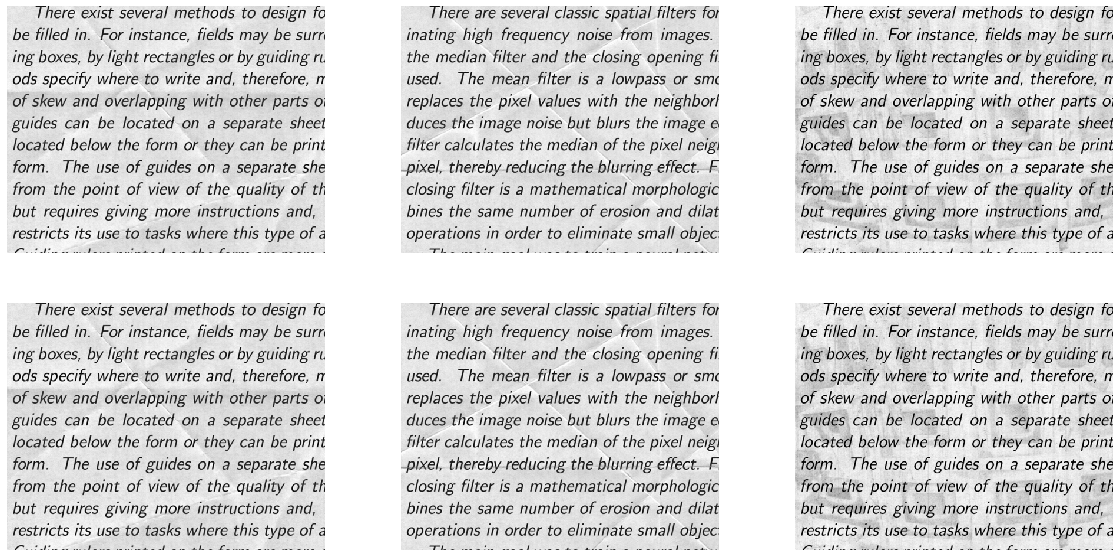

In [8]:
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()    

### Build Autoencoder

In [9]:
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    # Encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    # Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    # Model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [10]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 210, 270, 64)     

### Store the images as array in list

In [11]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [12]:
X[0].shape

(420, 540, 1)

### Split the dataset into training and validation dataset

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


### Train the model with the image dataset

In [14]:
autoencoder.fit(X_train, y_train, epochs=16, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/16
17/17 [==============================] - 121s 7s/step - loss: 0.4394 - val_loss: 0.3740
Epoch 2/16
17/17 [==============================] - 122s 7s/step - loss: 0.3456 - val_loss: 0.3347
Epoch 3/16
17/17 [==============================] - 122s 7s/step - loss: 0.3016 - val_loss: 0.2689
Epoch 4/16
17/17 [==============================] - 123s 7s/step - loss: 0.2473 - val_loss: 0.2367
Epoch 5/16
17/17 [==============================] - 122s 7s/step - loss: 0.2172 - val_loss: 0.2116
Epoch 6/16
17/17 [==============================] - 119s 7s/step - loss: 0.1934 - val_loss: 0.1923
Epoch 7/16
17/17 [==============================] - 121s 7s/step - loss: 0.1775 - val_loss: 0.1865
Epoch 8/16
17/17 [==============================] - 117s 7s/step - loss: 0.1696 - val_loss: 0.1762
Epoch 9/16
17/17 [==============================] - 111s 7s/step - loss: 0.1640 - val_loss: 0.1705
Epoch 10/16
17/17 [==============================] - 112s 7s/step - loss: 0.1588 - val_loss: 0.1665
Epoch 11/

KeyboardInterrupt: 

### Test the model with sample image data

In [3]:
autoencoder = keras.models.load_model("D:\\Projetos\\Python\\projetos\\CleanOCR\\resources\\model")

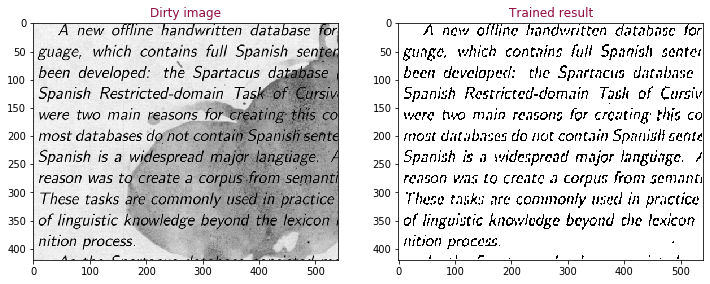

In [18]:
path = "D:\\Projetos\\Python\\projetos\\CleanOCR\\resources\\1.dirty\\6.png"
sample_test = load_img(test / test_images[-1], grayscale=True, target_size=(420, 540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')

ax[0].set_title('Dirty image', color='#900c3f')
ax[1].set_title('Trained result', color='#900c3f')

plt.show()

In [5]:
predicted_label

array([[1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       ...,
       [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 0.000000e+00,
        9.332287e-02, 1.000000e+00],
       [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.493117e-18,
        1.000000e+00, 1.000000e+00],
       [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00]], dtype=float32)

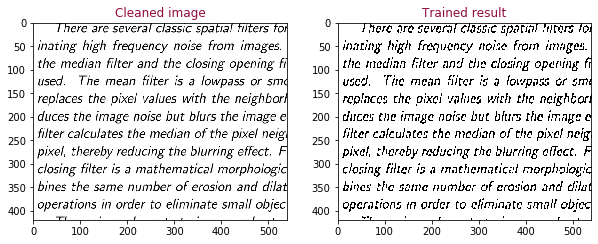

In [20]:
sample_test = load_img(train_cleaned/ train_images[-1], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')
sample_test_img = np.expand_dims(sample_test_img, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')

ax[0].set_title('Cleaned image', color='#900c3f')
ax[1].set_title('Trained result', color='#900c3f')

plt.show()

In [11]:
sample_test.shape

(420, 540, 1)

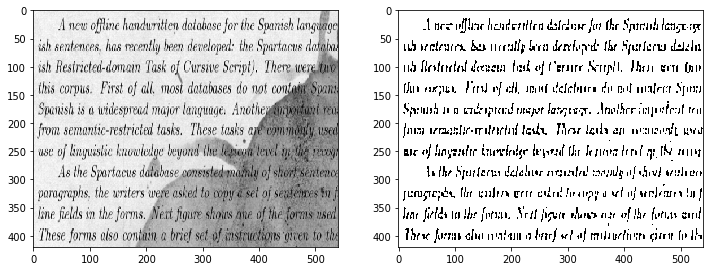

In [13]:
path = "D:\\Projetos\\Python\\projetos\\CleanOCR\\resources\\1.dirty\\3.png"

sample_test = load_img(path, grayscale=True, target_size=(420, 540))
sample_test_arr = img_to_array(sample_test)
sample_test_vec = np.expand_dims(sample_test_arr, axis=0)

predicted_label = autoencoder.predict(sample_test_vec)
predicted_label = np.squeeze(predicted_label)
predicted_label

f, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].imshow(sample_test, cmap='gray')
ax[1].imshow(predicted_label.astype('int8'), cmap="gray")

plt.show()

In [15]:
sample_test_vec.shape

(1, 420, 540, 1)

In [16]:
sample_test_arr.shape

(420, 540, 1)

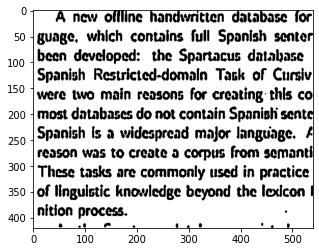

In [65]:
ee = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
r = cv2.equalizeHist(predicted_label.astype(np.uint8))

erod = cv2.erode(r, ee)


plt.imshow(erod, cmap="gray")
plt.show()

In [15]:
autoencoder.save("D:\\Projetos\\Python\\projetos\\CleanOCR\\resources\\model\\")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: D:\Projetos\Python\projetos\CleanOCR\resources\model\assets


In [20]:
print(type(np.squeeze(sample_test)))

<class 'numpy.ndarray'>


## Compute uqi, psnr, rmse, ssim

In [21]:
sample = np.squeeze(sample_test)
print("Shape:", sample.shape)
print(type(sample))

Shape: (420, 540)
<class 'numpy.ndarray'>


In [22]:
print(predicted_label.shape)
print(type(predicted_label))

(420, 540)
<class 'numpy.ndarray'>


### Compute RMSE

In [23]:
print("RMSE:", rmse(sample, predicted_label))

RMSE: 234.28383861034197


### Computer UQI

In [19]:
print("UQI:", uqi(sample, predicted_label))

UQI: 6.208933023927608e-05


### Save the results on S3 bucket

In [37]:
import boto3

# Specify the name of the bucket
bucket_name = "denoise-docs"

s3 = boto3.client("s3")

# Local file that need to be uploaded
filename = 'output.png'

# Upload result on S3 bucket
s3.upload_file(
    Bucket = bucket_name,
    Filename=filename,
    Key=filename
)